# Getting started

In [13]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import lightkurve as lk

Let's download a nice star that has good time-delays -- KIC 9651065.

/Users/danielhey/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:212: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Plotting PDCSAP_FLUX. You can remove this warning by using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


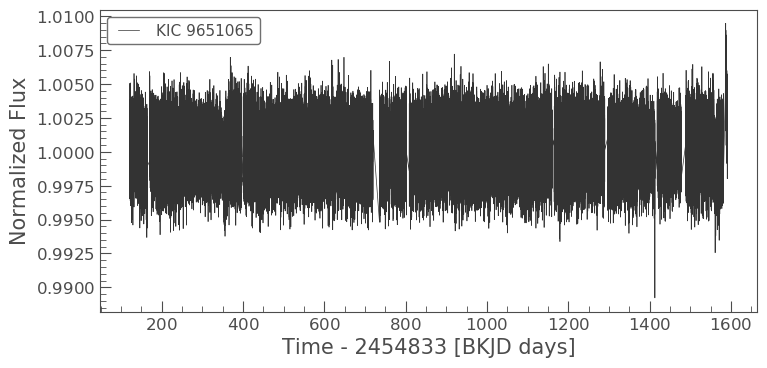

In [2]:
lc = lk.search_lightcurvefile('KIC 9651065', mission='Kepler').download_all().stitch().remove_nans()
lc.plot()

Here, we pass the time and flux data into Maelstrom. Note that lightkurve automatically subtracts the Kepler zero time (2454844 days). If you want to include additional data, you must work within the same reference time. If the `freq` argument is not specified, Maelstrom will automatically try and detect some good peaks. Be warned however, this does not always work and you should always check which frequencies you use! I have set the upper limit on the peak search to 40 cpd, since there are some Nyquist aliases. We can tell they are aliases as their time delays will match the Kepler orbital period. Neat!

First look will subdivide the lightcurve using the old method, and have a quick look at the orbital signal. The frequencies are colored by their amplitude, and the orange line is the weighted average value. We see a nice peak around 272 d, which is the orbital period.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1db287f0>,
      dtype=object)

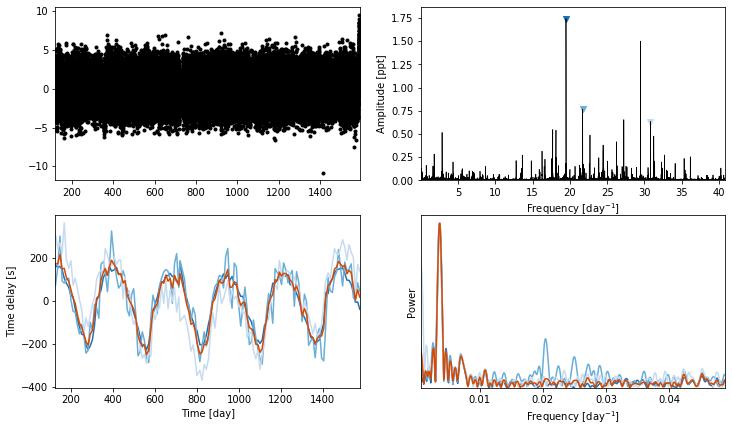

In [3]:
from maelstrom import Maelstrom

ms = Maelstrom(lc.time, lc.flux, max_peaks=3, fmin=5, fmax=40)
ms.first_look()

Let's now perform an initial optimisation..
We first need to call `setup_orbit_model`, but an orbital period estimate is not required (unless the time delay signal is very weak..!). We then optimize the model

In [4]:
ms.setup_orbit_model(period=272.)
opt = ms.optimize()

In [5]:
opt

{'logperiod': array(5.60521921),
 't0': array(15.39716148),
 'varpi_angle__': array([ 3.64011013, -2.59799886]),
 'eccen_interval__': array(-0.19682943),
 'logs': array(0.21291598),
 'lighttime': array([178.34565494, 191.3003582 , 193.97127067]),
 'mean_flux': array(0.00075224),
 'W_hat_cos': array([ 1.7414353 ,  0.46678729, -0.59316665]),
 'W_hat_sin': array([ 0.29408812,  0.62832871, -0.28794188]),
 'period': array(271.84151029),
 'varpi': array(2.19066738),
 'eccen': array(0.45095187),
 'tref': array(24.82833308)}

Let's see what the theoretical time delays look like

Text(0, 0.5, 'Time delay [s]')

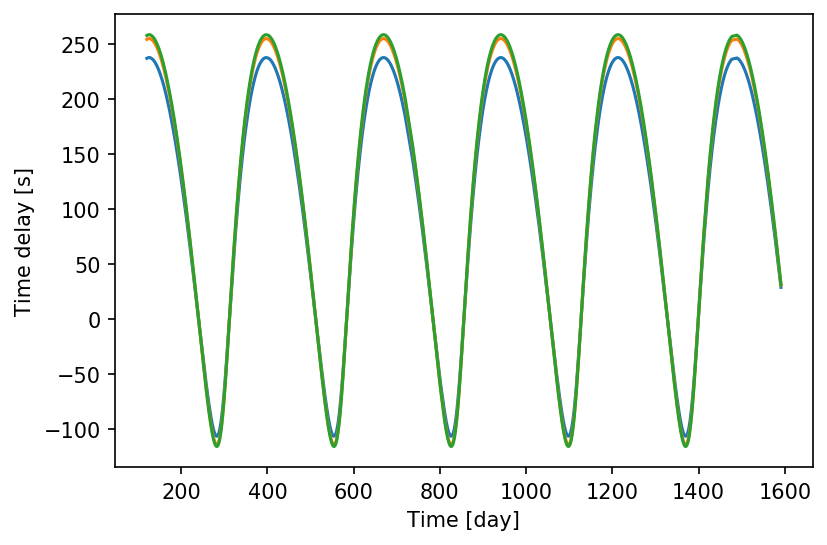

In [15]:
with ms:
    plt.plot(ms.time, xo.eval_in_model(ms.tau, opt) * 86400)
    
plt.xlabel('Time [day]')
plt.ylabel('Time delay [s]')

Cool! Each frequency in the light curve has its own independent `asini` in the Maelstrom model. This is useful for when there are multiple stars pulsating in the same binary system, as they would be (mostly) equal and opposite in sign.

Maelstrom has decided that all these frequencies belong to one star, as their lighttimes are all positive (or negative). This means the system is PB1. We can get a ready-made model from the get go by asking nicely, and passing in the optimisation results. The PB1 model is for binaries with only one pulsating component. All the frequencies now use the same `asini` parameter, unlike our first model

In [6]:
pb1_model = ms.pin_orbit_model(opt)
pb1_model

As we can see, pb1_model inherits from the PyMC3 Models object. It is, by definition, a custom model which has access to all of the properties of the default Model class. This means we can do cool things like this:

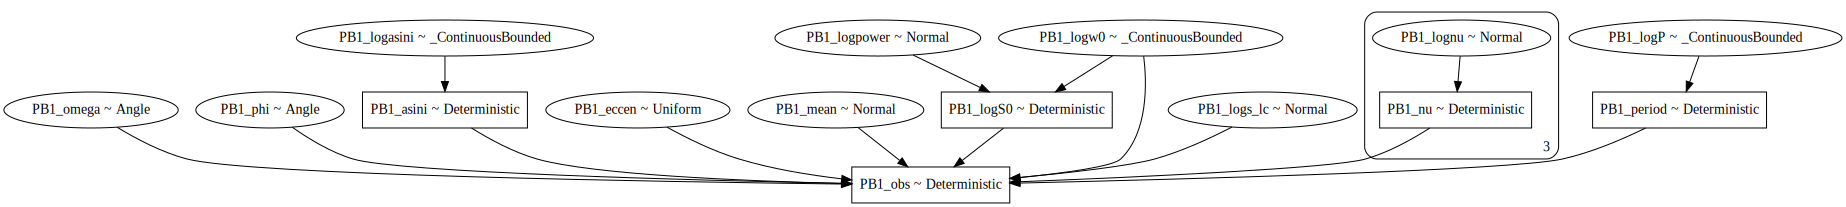

In [8]:
pm.model_to_graphviz(pb1_model)

Finally, if we are happy with the default priors in Maelstrom we can sample the model. Otherwise, see the tutorial on setting up custom priors!

In [17]:
trace = pb1_model.sample(tune=1000, draws=1000)

optimizing logp for variables: [PB1_mean]
5it [00:00, 19.64it/s, logp=-1.124302e+05]
message: Optimization terminated successfully.
logp: -112430.23569362523 -> -112430.23430331374
optimizing logp for variables: [PB1_logs_lc]
9it [00:00, 22.53it/s, logp=-1.090380e+05]
message: Optimization terminated successfully.
logp: -112430.23430331374 -> -109037.96061965273
optimizing logp for variables: [PB1_logw0, PB1_logpower]
126it [00:05, 21.60it/s, logp=-1.072571e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -109037.96061965273 -> -107257.13376770144
optimizing logp for variables: [PB1_omega, PB1_eccen]
138it [00:07, 18.96it/s, logp=-1.039395e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -107257.13376770144 -> -103939.50240136718
optimizing logp for variables: [PB1_phi]
21it [00:01, 12.63it/s, logp=-1.039178e+05]
message: Optimization terminated successfully.
logp: -103939.50240136718 -> -103917.84577691373
optimizing lo

ValueError: Not enough samples to build a trace.